# **Precios internacionales y domésticos del gas y del petróleo**


---


El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos del precio del gas natural y del petróleo, tanto nacional como internacional.

El análisis de los precios de los hidrocarburos permite identificar brechas entre los precios nacionales e internacionales, al mismo tiempo que es fundamental para entender el destino de las divisas argentinas utilizadas para la importación.

Como resultado del análisis de datos, se presentan dos figuras que permiten una visualización de la evolución de los precios nacionales e internacionales de los hidrocarburos.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import datetime as dt
from datetime import date
import plotly.graph_objects as go
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00


### Creación de función de extracción y limpieza

Los archivos necesarios para la obtención de los precios domésticos del gas y del petróleo corresponden a los informes de Regalías del Gas y del Crudo, respectivamente.

Dichos informes son publicados en forma de un archivo `.xlsx` (Excel) que se encuentra dentro de un archivo `.zip`. Dado que la *library* `pandas` no lee archivos `.zip` directamente, se crea una función (`domestic_prices`) que permite la lectura de estos archivos.

En particular, se utilizan las *libraries* `request` e `io` para extraer los archivos guardados "dentro" del archivo `.zip` y guardarlos en la memoria de la interfaz.

Una vez extraido el archivo, se procede a su lectura utilizando la *library* `pandas`. En particular, se lee solamente la hoja "Tabla precios", y se ignoran las primeras 12 filas.

Por otra parte, la función `domestic_prices` también permite la *limpieza* del *DataFrame*. Así, dado que el análisis se efectúa a partir del año 2010 (en el caso del gas natural) y del 2003 (en el caso del petróleo), se eliminan todas los datos anteriores a dichas fechas. Acto seguido, se resetea el índice y se utilizan solo las columnas deseadas, dispuestas en una lista (`list_of_columns`) para cada *DataFrame* en particular.

Además, los archivos de Regalías (tanto del Gas como del Crudo) contienen, en la columna "AÑO", valores `NaN`. Estos valores deben ser eliminados con `.fillna()` utilizando el método "ffill" (o *forward-fill*), que rellena los `NaN` con la última observación válida.

La columna "Período" puede servir como un índice temporal, de la siguiente manera:
1.   La columna "AÑO" debe ser interpretada como un número entero: `.astype(int)`
2.   Las columnas "AÑO" y "MES" deben ser interpretadas como cadenas de texto: `.astype(str)`.
3.   La columna "Período" surge de la transformación en `datetime` (`pd.to_datetime`) de una cadena de texto conformada por: "AÑO" + "MES" + "1", donde "1" es el día. Se aplica el formato correspondiente.

La función `domestic_prices` recopila todo lo anterior y lo generaliza para cualquier *DataFrame*.

In [3]:
def domestic_prices(url, df, max_row, list_of_columns):
  request = requests.get(url)
  zip_file = zipfile.ZipFile(io.BytesIO(request.content))
  zip_file.extractall()
  df = pd.read_excel(f"/content/{zip_file.namelist()[0]}", sheet_name="Tabla precios", skiprows=12)
  df = df.drop(df.index[0:max_row]).reset_index(drop=True)[list_of_columns]
  df = df.fillna(method="ffill")
  df['AÑO'] = df['AÑO'].astype(int)
  df['AÑO'] = df['AÑO'].astype(str)
  df['MES'] = df['MES'].astype(str)
  df['Período'] = pd.to_datetime(df["AÑO"]+df["MES"]+"1", format="%Y%m%d")
  return df

## Gas natural

El gas natural es extraido en Argentina de diversas cuencas (tanto *on-shore* como *off-shore*. Al mismo tiempo, el país es importador de Gas Natural en estado gaseoso proveniente de Bolivia, así como de Cargueros de Gas Natural Licuado.

### Precios domésticos

#### Obtención y limpieza de los datos

Los precios nacionales del gas natural surgen del Informe de Regalías del Gas, publicado mensualmente por la Secretaría de Energía.

El link `url_gas` remite a dicho archivo.

In [4]:
url_gas = "http://www.energia.gob.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/mercado_hidrocarburos/informacion_estadistica/regalias/Regalias_GAS.zip"

La ejecución de la función `domestic_prices()` permite la obtención del archivo a partir de `url_gas` y su limpieza.

Es necesario identificar un `pandas.DataFrame` (en este caso, `domesticos_gas`) y una lista `list_of_columns` a utilizar (`columnas_gas`).

In [5]:
domesticos_gas = pd.DataFrame()

In [6]:
columnas_gas = ["AÑO", "MES", "TOTAL CUENCA"]

In [7]:
domesticos_gas = domestic_prices(url_gas, domesticos_gas, 204, columnas_gas)

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Slicer List extension is not supported and will be removed
  warn(msg)


La columna "TOTAL CUENCA" es renombrada como "Ponderado Argentina".

In [8]:
domesticos_gas = domesticos_gas.rename(columns={"TOTAL CUENCA": "Ponderado Argentina"})

Se eliminan las columnas innecesarias y se reordena el *DataFrame*.

In [9]:
domesticos_gas = domesticos_gas[["Período", "Ponderado Argentina"]]

Los montos de la columna "Ponderado Argentina" se encuentran en $/Mm3 (pesos argentinos por metro cúbico).

Es preciso convertirlos a US$ / MMBTU (dólares estadounidenses por millón de BTU).

El valor del tipo de cambio se extrae directamente de la serie del Tipo de Cambio Nominal Promedio Mensual (TCNPM), publicada por el Banco Central de la República Argentina.

In [10]:
url_tc = "https://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/com3500.xls"

Se utiliza `pandas` para leer el archivo `.xls`. Se lee solo la página "Serie de TCNPM", con las columnas "Mes" y "Tipo de cambio nominal promedio mensual". Esta última columna es renombrada para facilitar el manejo del *DataFrame*.

Por último, se utilizan solo las filas deseadas `[94:]` y se reseta el índice (`.reset_index()`). 

In [11]:
tc = pd.read_excel(url_tc, sheet_name="Serie de TCNPM", skiprows=1, usecols=["Mes", "Tipo de cambio nominal promedio mensual"]).drop([0]).rename(columns = {"Tipo de cambio nominal promedio mensual": "TCN"})[94:].reset_index(drop=True)

Se utiliza el siguiente conversor de Mm3 a MMBTU para el gas natural.

In [12]:
conversor_MM3_MMBTU = 38.0096775807296

Para obtener el valor de la columna "Ponderado Argentina" en US$ / MMBTU, se divide por el valor del tipo de cambio y por el conversor de Mm3 a MMBTU.

In [13]:
domesticos_gas['Ponderado Argentina'] = domesticos_gas['Ponderado Argentina']/tc['TCN']/conversor_MM3_MMBTU

### Precios internacionales

Los precios internacionales del gas natural (tanto el gas importado de Bolivia como aquel de los Cargueros de Gas Natural Licuado) se encuentran en fuentes dispersas y cambiantes, haciendo imposible una sistematización del proceso de obtención de datos.

En su lugar, se propone un enfoque "manual", en el que el cálculo del precio internacional se efectúa manualmente y, luego, se agrega a las listas `precios_bolivia` y `precios_GNL` presentadas a continuación.

Visualmente, cada fila de cada una de las listas representa los 12 datos mensuales de un año, desde el 2010 hasta el presente.

Los precios del gas natural en estado gaseoso (proveniente de Bolivia) y los de los cargueros de Gas Natural Licuado son calculados a partir de la información provista por el informe mensual del Intercambio Comercial Argentino (ICA) publicado por el Instituto Nacional de Estadísticas y Censos (INDEC) y por los Partes Diarios de Importación de Gas Natural, publicados por el Ente Nacional Regulador del Gas (ENARGAS).

In [14]:
precios_bolivia = [
  6.99, 6.99, 6.99, 7.371, 7.371, 7.371, 7.4086, 7.4086, 7.4086, 7.33, 7.33, 7.33,
  7.6034, 7.6034, 7.6034, 8.77, 8.77, 8.77, 10.2, 10.2, 10.2, 10.6765, 10.6765, 10.6765,
  10.6258, 10.6258, 10.6258, 11.0794, 11.0794, 11.0794, 11.17, 11.17, 11.17, 10.78, 10.78, 10.78,
  10.59, 10.59, 10.59, 10.51, 10.51, 10.51, 10.32, 10.32, 10.32, 10.11, 10.11, 10.11,
  10.16, 10.16, 10.16, 10.1442, 10.1442, 10.1442, 10.2044, 10.2044, 10.2044, 9.9075, 9.9075, 9.9075,
  8.3495, 8.3495, 8.3495, 6.0776, 6.0776, 6.0776, 5.4, 5.4, 5.4, 4.9863, 4.9863, 4.9863,
  3.8871, 3.8871, 3.8871, 3.0686, 3.0686, 3.0686, 3.1934, 3.1934, 3.1934, 3.9031, 3.9381, 3.9381,
  4.451, 4.451, 4.451, 4.9432, 4.9432, 4.9432, 4.9858, 4.9858, 4.9858, 5.0, 5.0, 5.0,
  5.46, 5.46, 5.46, 5.96, 5.96, 5.96, 6.49, 6.49, 6.49, 7.04, 7.04, 7.04,
  7.1, 7.1, 7.1, 6.57, 6.57, 6.57, 6.43, 6.43, 6.43, 6.62, 6.62, 6.62,
  6.44, 6.44, 6.44, 5.7, 5.7, 5.7, 4.11, 4.11, 4.11, 3.68, 3.68, 3.68,
  4.5, 4.5, 4.5, 5.3, 5.2, 5.3, 6.0, 5.3, 6.3, 7.1, 7.0, 6.9,
  7.6, 7.7, 15.4, 8.9, 13.6, 12.9, 12.9, 13.1, 11.2329792576729, 10.380283488698762, 10.40319309993011, 12.1850062732353,
  9.12777857984474]

In [15]:
precios_GNL = [
  np.nan, 8.214394569424366, 7.546011671990557, 6.103403700025681, 6.880356483078922, 6.553995755490796, 7.317784745696346, 7.368165266245698, 7.189658943592039, 9.125039034263779, 8.851466377034088, 9.974788065499908,
  9.399307680226599, 9.472937560630506, 9.374120801628498, 9.992439669922652, 12.094665860612833, 13.20379693540693, 12.191081072400614, 14.599341694333997, 12.582582206806864, 12.499641730453366, 14.02726303542479, 14.224070135624538, 
  16.224847931383863, 15.464663828991299, 15.434509832107908, 14.792273297164929, 15.58502122473244, 15.81216446686998, 16.379369263078672, 15.987615781029922, 15.136219844346199, 15.519176707967208, 15.544893236476637, 15.863410447877483,
  16.048378807186314, 15.707424820951829, 16.6376927715413, 16.657782750138022, 20.114252389332233, 16.473504426983823, 16.088608837011286, 15.910392209626005, 17.980851895634864, 15.926467199932588, 15.92033498267989, 15.718162627353832,
  9.958779173082553, 10.696819935563532, 14.843359806883306, 17.98105199966093, 16.117813395932245, 15.892912247103707, 15.905693938496892, 14.237155950094841, 14.10413794758606, 13.561187472623692, 13.79402967341647, 13.97663582153286,
  12.22010064763165, 11.399174432506117, 13.133244015355636, 11.992480628739424, 10.917510200404317, 11.988923633529165, 11.544895985472929, 11.332444955549205, 8.627708506764515, 9.093363718954574, 6.855071000545253, 6.800121572163438,
  8.662668893449553, 5.598058038933889, 5.615094994802315, 4.94066099988434, 4.648199653751435, 4.671829755419534, 5.200638854336538, 5.411888199919174, 6.441902588198022, 6.877504130774605, np.nan, np.nan,
  np.nan, np.nan, 6.950071931189841, 6.217838572370968, 6.068508087424926, 5.680978810493507, 5.530985828020734, 5.2981562050034645, 5.630327876813947, 6.2971024794617865, np.nan, np.nan, 
  np.nan, np.nan, np.nan, 7.512936320428825, 7.096697744896704, 6.8, 7.0, 8.1, 10.0, np.nan, np.nan, np.nan, 
  np.nan, np.nan, np.nan, np.nan, 6.2, 6.4, 6.3, 5.5, 4.3, np.nan, np.nan, np.nan, 
  np.nan, np.nan, np.nan, 2.7, 2.7, 2.7, 2.3, 2.7, 3.0, np.nan, np.nan, np.nan, 
  np.nan, np.nan, np.nan, 6.4, 6.7, 7.5, 8.1, 10.4, 12.8, np.nan, np.nan, np.nan,
  np.nan, np.nan, np.nan, 33.0, 40.2, 39.6, 25.1, 24.3, np.nan, np.nan, np.nan, np.nan,
  0]

Ambas listas son transformadas en *dictionaries*.

In [16]:
GNL = dict(zip(domesticos_gas["Período"].tolist(), precios_GNL))

In [17]:
bolivia = dict(zip(domesticos_gas["Período"].tolist(), precios_bolivia))

### *DataFrame* final


Luego, cada *dictionary* es *mapeado* (`.map()`) al *DataFrame* final (`precios_gas`).

Debido a que la importación de Gas Natural Licuado es intermitente (con picos de importación durante el invierno), la columna "Carguero Gas Natural Licuado" presenta múltiples valores `NaN`, que representan aquellos meses en los que las cantidades importadas fueron nulas.

In [18]:
precios_gas = domesticos_gas.copy()

In [19]:
precios_gas["Carguero Gas Natural Licuado"] = precios_gas["Período"].map(GNL)

In [20]:
precios_gas["Gas de Bolivia"] = precios_gas["Período"].map(bolivia)

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [21]:
precios_gas.tail()

,Período,Ponderado Argentina,Carguero Gas Natural Licuado,Gas de Bolivia
152,2022-09-01,4.016446,NaN,11.232979
153,2022-10-01,3.231890,NaN,10.380283
154,2022-11-01,3.291148,NaN,10.403193
155,2022-12-01,3.198456,NaN,12.185006
156,2023-01-01,3.310217,0.0,9.127779


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [22]:
precios_gas.to_excel("Precios internacionales y domésticos del gas.xlsx", index=False)

## Petróleo

Al igual que el gas natural, el crudo es extraido en Argentina de diversas cuencas (tanto *on-shore* como *off-shore*). Se toma como precio internacional de referencia al crudo Brent, del Mar del Norte, y al precio de exportación argentino (regulado por el Decreto 488/2020).

### Precios domésticos

#### Obtención y limpieza de los datos

Los precios nacionales del crudo del Informe de Regalías del Crudo, publicado mensualmente por la Secretaría de Energía.

El link (`url_crudo`) remite a dicho archivo.

In [23]:
url_crudo = "http://www.energia.gob.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/mercado_hidrocarburos/informacion_estadistica/regalias/Regalias_CRUDO.zip"

La ejecución de la función `domestic_prices()` permite la obtención del archivo a partir de `url_crudo` y su limpieza.

Es necesario identificar un `pandas.DataFrame` (en este caso, `domesticos_crudo`) y una lista `list_of_columns` a utilizar (`columnas_crudo`).

In [24]:
domesticos_crudo = pd.DataFrame()

In [25]:
columnas_crudo = ["AÑO", "MES", "CUENCA GOLFO SAN JORGE", "CUENCA NEUQUINA"]

In [26]:
domesticos_crudo = domestic_prices(url_crudo, domesticos_crudo, 144, columnas_crudo)

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Slicer List extension is not supported and will be removed
  warn(msg)


Las columnas "CUENCA GOLFO SAN JORGE" y "CUENCA NEUQUINA" se renombran a partir de los crudos producidos en dichas cuencas: Escalante y Medanito, respectivamente.

In [27]:
domesticos_crudo = domesticos_crudo.rename(
  columns={
    "CUENCA GOLFO SAN JORGE": "Crudo Escalante",
    "CUENCA NEUQUINA": "Crudo Medanito"
  })

Se eliminan las columnas innecesarias y se reordena el *DataFrame*.

In [28]:
domesticos_crudo = domesticos_crudo[["Período", "Crudo Medanito", "Crudo Escalante"]]

Los montos de las columnas "Medanito" y "Escalante" US$ / m3 (dólares estadounidenses por metro cúbico).

Es preciso convertirlos a US$ / bbl (dólares estadounidenses por barril).

Se utiliza el siguiente conversor de m3 a bbl para el crudo.

In [29]:
conversor_m3_bbl = 6.289814

Para obtener el valor de las columnas en US$ / bbl, se divide el valor de cada columna por el conversor de m3 a bbl.

In [30]:
for column in domesticos_crudo.columns[1:]:
  domesticos_crudo[column] = domesticos_crudo[column]/conversor_m3_bbl

### Precios internacionales

#### Crudo Brent

Extraido del Mar del Norte, el crudo Brent es referencia del precio en el mercado petrolero europeo.

Los datos del precio del Brent son obtenidos a partir del relevamiento mensual por parte de la Energy Information Administration (EIA) de Estados Unidos. El link `url_brent` refiere a dicho archivo.

In [31]:
url_brent = "https://www.eia.gov/dnav/pet/hist_xls/RBRTEm.xls"

Se utiliza la *library* `pandas` para leer la hoja "Data 1" del archivo, ignorando sus dos primeras filas.

In [32]:
brent = pd.read_excel(url_brent, sheet_name="Data 1", skiprows=2)

Dado que el análisis se efectúa a partir del año 2003, se eliminan todas los datos anteriores a enero de dicho año (filas `[0:188]`) y se resetea el índice.

In [33]:
brent = brent.drop(brent.index[0:188]).reset_index(drop=True)

Acto seguido, se renombran las columnas.

In [34]:
brent = brent.rename(
  columns={
    "Date": "Período",
    brent.columns[1]: "Brent"
  })

Por último, se convierte en formato `datetime` la columna "Período", y se reemplazan todos los días por el primer día de cada mes.

In [35]:
brent['Período'] = pd.to_datetime(brent['Período']).apply(lambda x: x.replace(day=1))

#### Precio de exportación

El precio de exportación argentino se encuentra regulado por el Decreto 488/2020.

Debido a que no existe una serie histórica de este tipo de crudo, la lista `precio_exportacion_historic` contiene todos los valores de una serie de tiempo armada manualmente, hasta el mes de mayo del año 2020 (a partir del cual se publica el Precio Internacional del Decreto 488/2020).

In [36]:
precios_exportacion_historic = [
  32.75454545454545, 35.786500000000004, 33.156190476190474, 28.24545454545455, 28.12, 30.519523809523808, 30.69, 31.59714285714286, 28.45954545454545, 30.345217391304345, 30.991500000000002, 32.175,
  34.18380952380952, 34.503, 36.71826086956522, 36.616666666666674, 40.28, 38.06772727272727, 40.69772727272727, 44.88363636363636, 45.84909090909091, 53.09380952380951, 48.56318181818183, 43.304782608695646,
  46.924285714285716, 48.068, 54.62954545454546, 53.21761904761905, 49.960909090909084, 56.419545454545464, 59.01285714285714, 64.99347826086957, 65.64454545454545, 62.268571428571434, 58.376363636363635, 59.401363636363634,
  65.25954545454545, 61.82350000000001, 62.96608695652175, 70.16105263157894, 70.979, 70.97, 74.412, 73.08347826086957, 63.909000000000006, 59.13681818181818, 59.38818181818181, 62.08649999999999,
  54.595909090909096, 59.388, 60.74045454545455, 64.04100000000001, 63.53, 67.52952380952381, 74.02590909090908, 72.3586956521739, 79.35, 85.66, 94.75, 91.37,
  92.82, 95.36, 105.42, 112.46, 125.76, 134.02, 134.0, 116.69, 104.3, 76.72, 57.29, 42.04,
  41.67, 39.17, 48.06, 49.94952380952381, 59.33, 69.69545454545457, 64.4, 71.14, 69.40227272727272, 75.82363636363635, 78.13619047619048, 74.6,
  78.38250000000001, 76.3365, 81.29, 84.57523809523812, 74.11749999999999, 75.43363636363634, 76.19, 76.66681818181819, 75.50545454545454, 81.9747619047619, 84.29409090909088, 89.33217391304345,
  89.67190476190474, 89.566, 102.98130434782607, 110.0385, 101.32181818181816, 96.28863636363639, 97.32894575297962, 86.3408695652174, 85.64818181818183, 86.42809523809524, 97.11772727272728, 98.5757142857143,
  100.24, 102.42, 100.51018092785145, 97.69849152596267, 89.124818913161, 76.88802982606761, 82.4322061114821, 88.60010222900569, 88.97631419123026, 84.00635616394798, 81.0758629845146, 82.39260485230056,
  89.22382206111483, 89.7683393748609, 87.42196476835512, 86.51113580717988, 88.97631419123026, 90.22375385544849, 99.03503402333939, 100.91609383446215, 100.63888502019144, 94.9462040128462, 88.33279372953037, 97.63,
  94.62, 100.82, 100.8, 102.07, 102.18, 105.79, 103.59, 96.54, 93.21, 84.4, 75.79, 59.29,
  47.22, 50.58, 47.82, 54.45, 59.27, 59.82, 50.9, 42.87, 45.48, 46.22, 42.44, 37.21,
  30.7, 32.18, 38.21, 41.58, 46.74, 48.25, 44.95, 45.84, 46.57, 49.52, 44.73, 53.29,
  54.58, 54.87, 51.59, 52.31, 50.33, 46.37, 48.48, 51.7, 56.15, 57.51, 62.71, 64.37,
  69.08, 65.32, 66.02, 72.11, 76.98, 74.41, 74.25, 72.53, 78.89, 81.03, 64.75, 57.36,
  59.41, 63.96, 66.14, 71.23, 71.32, 64.22, 63.92, 59.04, 62.83, 59.71, 63.21, 67.31,
  63.65, 55.66, 32.01, 18.38, 29.38]

Se transforma la lista en *dictionary*.

In [37]:
exportacion_historic = dict(zip(domesticos_crudo["Período"].tolist(), precios_exportacion_historic))

Los valores a partir de mayo del año 2020 son publicados por la Secretaría de Energía de la Nación, bajo el título del "Precio Internacional del Petróleo" según el artículo 7, inciso C, del Decreto 488/2020.

El link `url_exportacion` refiere a dicho archivo.

In [38]:
url_exportacion = "http://www.energia.gob.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/mercado_hidrocarburos/pi/precio_internacional.xlsx"

Se utiliza la *library* `pandas` para leer el archivo.

In [39]:
exportacion = pd.read_excel(url_exportacion, skiprows=2, skipfooter=2)

Se recorta el *DataFrame* con las columnas deseadas y se invierte su orden. Luego, se resetea el índice.

In [40]:
exportacion = exportacion[["Vigencia desde", "U$S/barril"]][::-1].reset_index(drop=True)

### *DataFrame final*



El armado del *DataFrame* final (`precios_crudo`) conjuga tanto los precios domésticos como los precios internacionales. En este sentido, se *mapea* (`.map()`) el precio del exportación al *DataFrame* y, luego, se agrega el precio del crudo Brent.

In [41]:
precios_crudo = domesticos_crudo.copy()

Para *mapear* los precios de exportación, se requiere que ambos se encuentren en un solo *dictionary*.

In [42]:
exportacion = {**exportacion_historic, **dict(exportacion.values)}

In [43]:
precios_crudo["Exportación"] = precios_crudo["Período"].map(exportacion)

En el caso del crudo Brent, dado que `brent` es, en esencia, un *DataFrame*, se unen ambos *DataFrames* (`.merge()`).

In [44]:
precios_crudo = precios_crudo.merge(brent, on="Período")

Así, se crea el *DataFrame* que contiene tanto los precios domésticos como los internacionales.

A continuación, se presentan las primeras 5 filas de dicho *DataFrame*.

In [45]:
precios_crudo.head()

,Período,Crudo Medanito,Crudo Escalante,Exportación,Brent
0,2003-01-01,26.276741,25.115804,32.754545,31.18
1,2003-02-01,26.937442,26.724067,35.786500,32.77
2,2003-03-01,27.906095,24.238090,33.156190,30.61
3,2003-04-01,26.598358,23.459694,28.245455,25.00
4,2003-05-01,25.346064,24.148734,28.120000,25.86


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [46]:
precios_crudo.to_excel("Precios internacionales y domésticos del petróleo.xlsx", index=False)

## Figuras

Se pretende crear una figura para cada *DataFrame* que refleje la evolución de los precios nacionales e internacionales de cada uno de los hidrocarburos. La representación será en forma de un gráfico de líneas.

### General

La lista `internationals` contiene aquellos precios que corresponden al mercado internacional.

In [47]:
internationals = precios_gas.columns[2:].tolist() + precios_crudo.columns[3:].tolist()

Para hacer más eficiente el código, se crean dos funciones que servirán para crear las figuras y modificar sus atributos esenciales.

La primera función (`precios_graph`) genera, a partir de un *DataFrame* determinado (`df`), el gráfico de líneas deseado.

Los parámetros de esta función son:


*   `df`: el *DataFrame* que contiene la información a graficar.
*   `color_list`: la lista de colores para cada una de las líneas.
*   `fig`: el nombre de la figura a utilizar.



In [48]:
def precios_graph(df, color_list, fig):
  for precio, color in zip(list(reversed(df.columns[1:].tolist())), color_list):
    if precio in internationals:
      fig.add_trace(
        go.Scatter(
          x=df["Período"],
          y=df[precio],
          mode='lines',
          line=dict(color=color, width=2),
          name=precio,
          legendgroup="Internacionales",
          legendgrouptitle_text="Internacionales"
        )
      )
    else:
      fig.add_trace(
        go.Scatter(
          x=df["Período"],
          y=df[precio],
          mode='lines',
          line=dict(color=color, width=2),
          name=precio,
          legendgroup="Nacionales",
          legendgrouptitle_text="Nacionales"
        )
      )
    fig.add_trace(go.Scatter(
      showlegend=False,
      x=df["Período"].tail(1),
      y=df[precio].tail(1),
      mode='markers+text',
      name=precio+"EoP",
      marker = dict(
          color = color,
          size = 10)
      )
    )
    fig.add_annotation(
      name = precio + " - Eop",
      x=dt.date(df["Período"][len(df)-1].year, df["Período"][len(df)-1].month, 1),
      y=df[precio][-1:].values[0],
      text=round(df[precio][-1:].values[0], 1).astype(str),
      font=dict(color=color),
      xanchor="left",
      xshift=5,
      yshift=0,
      showarrow=False
      )

La segunda función, `update_layout_fig` contiene el código para modificar el aspecto de la figura en general.

Sus parámetros son:


*   `fig`: el nombre de la figura a utilizar.
*   `date_start`: fecha en la que comienza el eje de abscisas.
*   `min`: valor mínimo del eje de ordenadas.
*   `max`: valor máximo del eje de ordenadas.
*   `title_text`: título del eje de ordenadas.



In [49]:
def update_layout_fig(fig, date_start, min, max, title_text):
  fig.update_layout(
    margin=dict(b=15, t=15, l=15, r=50),
    height=750, 
    width=1000,
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        orientation='h',
        xanchor='center', 
        x=0.5, 
        yanchor='bottom', 
        y=1,
        font=dict(size=16)
        ),
    xaxis=dict(
        range=[date_start, dt.date(date.today().year, date.today().month, 1)], tickformat="%m\n<b>%Y", dtick="M12"
        ),
    yaxis=dict(
        range=[min, max], title=dict(text=title_text), showgrid=True, gridcolor='lightgray'
        ),
    font=dict(
        size=14,
        family="Serif"
        )
    )

### Figura: Precios internacionales y domésticos del gas

La escala de colores elegida para el gas es una escala ternaria.

In [50]:
colors_gas = ['rgb(118, 78, 159)', 'rgb(204, 97, 176)', 'rgb(47, 138, 196)']

Como comentado anteriormente, la intermitencia de la importación del Gas Natural Licuado se refleja en los múltiples valores `NaN` en la columna "Carguero Gas Natural Licuado" del *DataFrame* `precios_gas`. Asimismo, la presencia de estos valores `NaN` implica que, al graficar los datos, existan períodos de corte en la serie (esto es, segmentos continuos no unidos).

Por motivos de visualización, se crea la serie `interpolation_GNL`, que contiene una interpolación lineal de los datos de la columna "Carguero Gas Natural Licuado".

In [51]:
interpolation_GNL = precios_gas[precios_gas.columns[2]].interpolate()

Se crea la figura `gas_fig` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [52]:
gas_fig = go.Figure()

Dicha figura es actualizada a partir de las funciones `precios_graph` y `update_layout_fig`, con los parámetros antes especificados.

Además, se agrega una `trace`, que grafica los valores de la serie `interpolation_GNL` como una línea discontinua (`dash = "dash"`). Visualmente, esta línea une los segmentos continuos de la serie de valores correspondientes al Carguero de Gas Natural Licuado.

In [53]:
precios_graph(precios_gas, colors_gas, gas_fig)

gas_fig.add_trace(
  go.Scatter(
    showlegend=False,
    x=precios_gas["Período"],
    y=interpolation_GNL,
    mode='lines',
    line=dict(color=colors_gas[1], width=2, dash="dash"),
    name="Interpolation GNL"
  )
)

update_layout_fig(gas_fig, dt.date(2010, 1, 1), -2, 45, "<b>USD / MMBTU")

A continuación, se exhibe la figura.

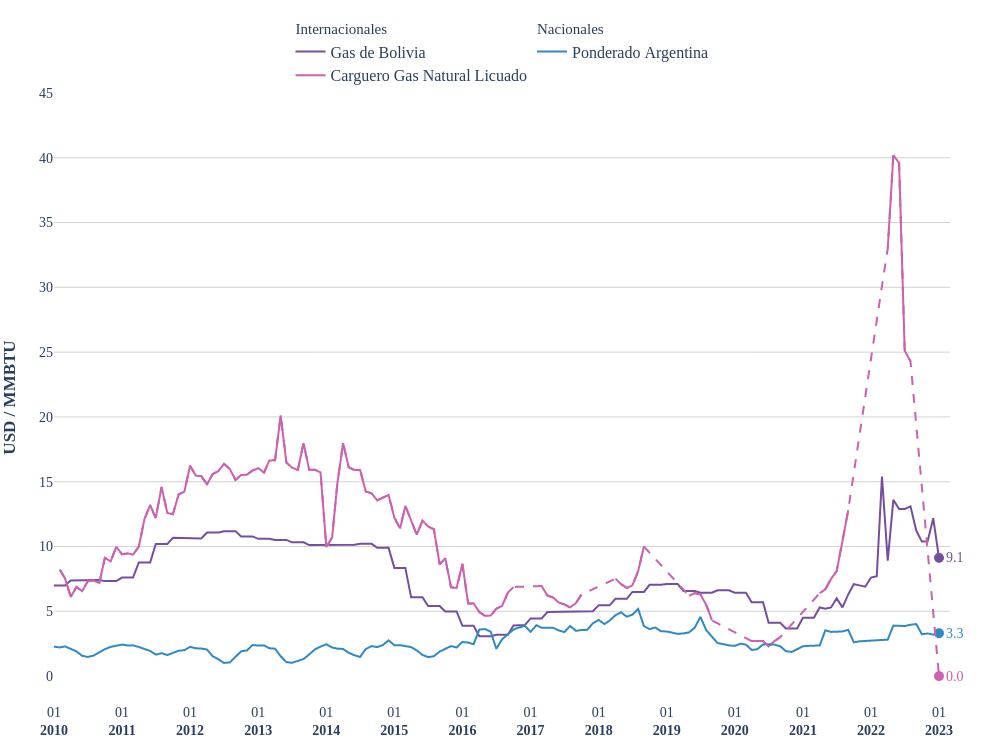

In [54]:
gas_fig.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [55]:
pio.write_image(gas_fig, "Figura Precios Int. y Dom. del Gas.pdf", width=3*300, height=2.25*300)

### Figura: Precios internacionales y domésticos del petróleo

La escala de colores elegida para esta figura es una escala cuaternaria.

In [56]:
colors_crudo = ['rgb(204, 97, 176)', 'rgb(153, 201, 69)', 'rgb(118, 78, 159)', 'rgb(47, 138, 196)']

Se crea la figura `crudo_fig` en el entorno de Plotly.

In [57]:
crudo_fig = go.Figure()

Dicha figura es actualizada a partir de las funciones `precios_graph` y `update_layout_fig`, con los parámetros antes especificados.

In [58]:
precios_graph(precios_crudo, colors_crudo, crudo_fig)


crudo_fig.update_annotations(
    selector = { "name": "Brent - Eop"},
    yshift=-5)

crudo_fig.update_annotations(
    selector = { "name": "Exportación - Eop"},
    yshift=5)

update_layout_fig(crudo_fig, dt.date(2003, 1, 1), -10, 150, "<b>USD / Bbl")

A continuación, se exhibe la figura.

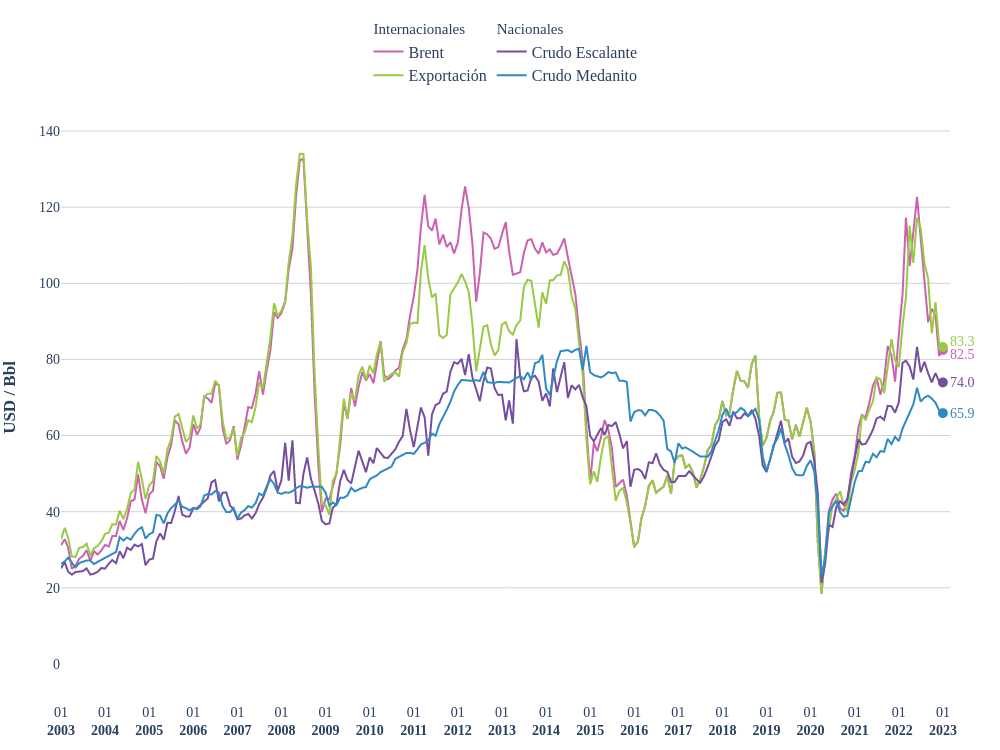

In [59]:
crudo_fig.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [60]:
pio.write_image(crudo_fig, "Figura Precios Int. y Dom. del Petroleo.pdf", width=3*300, height=2.25*300)